In [1]:
# Standard Imports
import cv2
import random
import scipy.signal as signal
import matplotlib.pyplot as plt
import skimage.morphology as morph
from skimage import feature
import skimage
from skimage import filters
import copy
import numpy as np
import glob
from collections import defaultdict
from skimage import segmentation
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import exposure
import imutils
from imutils import contours
import os
from typing import Any, List, Tuple, Dict, Union
import pandas as pd

# This should be true if you want to save the resulting images to disk.
SAVE = False

# Utility
Here we have functions that load the data and images from disk, as well as some plotting functions.

In [2]:
def get_img_and_data(name: str) -> Tuple[np.ndarray, np.ndarray]:
    """Gets the image and data (i.e. sudoku grid) from a filename.
        All paths are relative to ../data/images, and should not contain any file extensions.

    Args:
        name (str): The name of the image, e.g. 'image1'

    Returns:
        Tuple[np.ndarray, np.ndarray]: [img, datagrid]
    """
    # Image in grayscale
    img = cv2.imread(f'../data/images/{name}.jpg', 0)
    # get .dat file
    with open(f'../data/images/{name}.dat', 'r') as f:
        lines = f.readlines()
    # fill in grid
    arr = np.zeros((9, 9))
    for i, line in enumerate(lines[2:]):
        line = line.strip()
        things = map(int, line.split(' '))
        for j, num in enumerate(things):
            arr[i, j] = num
    return img, arr

In [3]:

def show_8(imgs: List[np.ndarray]):
    """Plots 8 images in 2 rows of 4. Grayscale

    Args:
        imgs (List[np.ndarray]): The images to plot.
    """
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.ravel()
    for img, ax in zip(imgs, axs):
        ax.imshow(img, cmap='gray')

def plot_81_things(imgs_81: List[np.ndarray]):
    """Plots a 9x9 grid.

    Args:
        imgs_81 (List[np.ndarray]): List of subblocks to plot. Should be in 1D
    """
    fig, axs = plt.subplots(9, 9, figsize=(10, 10))
    axs = axs.ravel()
    for img, ax in zip(imgs_81, axs):
        ax.imshow(img, cmap='gray')
    plt.tight_layout()

def show_8_81(imgs: List[List[np.ndarray]]):
    """Shows 8 grids of 9x9 subgrids in 2 rows of 4.

    Args:
        imgs (List[List[np.ndarray]]): Images to plot
    """
    fig, axs = plt.subplots(9 * 2, 9 * 4, figsize=(20, 10))
    for a in axs.ravel(): a.axis("off")
    for index, img in enumerate(imgs):
        R = index // 4
        C = index % 4
        for j, smallimg in enumerate(img):
            r = j // 9
            c = j % 9
            ax = axs[R * 9 + r, C * 9 + c]
            ax.imshow(smallimg, cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    plt.tight_layout()

# Initial - Segmenting Main Grid and Thresholding

In [4]:
def get_main_sudoku_grid_from_image(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Crops the sudoku grid from the main image and returns an image with only the grid in.

    Args:
        img (np.ndarray):

    Returns:
        Tuple[np.ndarray, np.ndarray]: Cropped image and original thresholded one (for reporting results, and not used in the method itself).
    """
    # Sobel
    edge_sobel = filters.sobel(img)
    # Threshold and remove noise.
    binary = (edge_sobel > filters.threshold_otsu(edge_sobel)).astype(np.uint8)
    binary = cv2.medianBlur(binary, 3)
    binary = filters.median(binary)
    # dilate
    binary = morph.dilation(binary)
    # Find contours
    contours,h = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    def area(c):
        (x, y, w, h) = cv2.boundingRect(c)
        return w * h
    # Find biggest contour and crop based on its bounding rect.
    contours = sorted(contours, key = area, reverse=True)[:1]
    x, y, w, h = cv2.boundingRect(contours[0])
    return img[y:y+h, x:x+w], binary

In [5]:
def thresh(img: np.ndarray) -> np.ndarray:
    """Thresholds the image locally and performs median filtering.

    Args:
        img (np.ndarray): 

    Returns:
        np.ndarray: 
    """
    ans = (img < filters.threshold_local(img, 151)) * 255
    ans = filters.median(ans, morph.square(5))
    return ans

In [6]:
def edge(img: np.ndarray) -> np.ndarray:
    """Perform edge detection and normalise image to between 0 and 1.

    Args:
        img (np.ndarray):

    Returns:
        np.ndarray:
    """
    filtered = (filters.sobel(img))#.astype(np.uint8)
    filtered = (filtered - filtered.min()) / (filtered.max() - filtered.min())
    return filtered

# Contour Detection

In [7]:
def contour_better(img: np.ndarray) -> np.ndarray:
    """Finds the contours of a sudoku grid

    Args:
        img (np.ndarray): Image to get contours for

    Returns:
        np.ndarray: Draws the contours on the image


    Inspiration and some code was taken from: https://www.pyimagesearch.com/2020/08/10/opencv-sudoku-solver-and-ocr/
    """
    img = img.copy()
    # Find the contours
    cnts, h = cv2.findContours(img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # Make the largest ones be first.
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    areas = [cv2.contourArea(c) for c in cnts]
    # For all contours, if it is small, then fill it in completely with 0 (i.e. black).
    # This causes smaller contours that represent the digits, or noise to be removed, leaving only the 
    # (relatively) larger gridlines themselves.
    for area, c in zip(areas, cnts):
        if area < 1800:
            # Fill with black if contour is small, and probably not a grid cell.
            cv2.drawContours(img, [c], -1, 0, -1)
    
    # Use closing by a vertical and horisontal kernel to repair some edges.
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, vertical_kernel, iterations=2)
    horis_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, horis_kernel, iterations=2)
    return img

In [8]:
def get_proper_gridlines(cropped_image: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns image containing lines from the Hough transform, the coordinates of those lines and the corresponding angles.

    Args:
        cropped_image (np.ndarray): Input image

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Line image, coordinates of lines, angles of lines.
    """
    image = cropped_image
    # Threshold. 
    image = image > filters.threshold_otsu(image)
    
    # Hough transform
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(image, theta=tested_angles)
    test = np.zeros_like(cropped_image)
    all_vals = []
    angles = []
    # For all angles
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        # Is it close to 90 degrees or 0 degrees, i.e. vertical or horisontal?
        if abs(abs(angle) - np.pi/2) < 0.2 or abs(angle) < 0.2:
            angles.append(angle)
            # Find two locations of the lines
            (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
            (y1, x1) = (np.array(image.shape)) * np.array([np.sin(angle+np.pi/2), np.cos(angle+np.pi/2)])
            init_pos = np.array([x0, y0])
            x1 += x0; y1 += y0
            # Create the vector representing the line.
            unit_vec = np.array([x1 - x0, y1 - y0])
            unit_vec /= np.linalg.norm(unit_vec)
            # The maximum possible length of the line
            l = int(np.sqrt(cropped_image.shape[0]**2 + cropped_image.shape[1]**2))
            # Minimum and maximum points on the lines, so we can recreate the lines when necessary.
            mins = (10000,10000)
            maxs = (-10000,-10000)
            # Then, fill in our initially empty image with the line pixels across the whole image.
            # This basically tries to perform the same operation that matplotlib.axline does, but on an image 
            for i in range(-l, l):
                new_pos = init_pos + i * unit_vec
                xx, yy = new_pos
                # If it is valid
                if 0 <= xx < cropped_image.shape[1] and 0 <= yy < cropped_image.shape[0]:
                    test[int(yy), int(xx)] = 1
                    mins = min(tuple(new_pos), mins)
                    maxs = max(tuple(new_pos), maxs)
            all_vals.append((mins, maxs))
    return test, all_vals, angles

In [9]:
def crop_based_on_hough_and_contours(hough_line_image: np.ndarray, img: np.ndarray, do_return_contours=False, do_fix_lines=True) -> Union[Tuple[int,int], List[Tuple[np.ndarray, np.ndarray]]]:
    """Takes in the line image, as well as the original grid and crops based on the line image and contours.

    Args:
        hough_line_image (np.ndarray): Line image output from `get_proper_gridlines`
        img (np.ndarray): Original grid image.
        do_return_contours (bool) If this is true, we return a, b instead of the normal return.
            a is the number of contours before performing cleaning, and b is the number of found contours after cleaning up.
            This can be used to determine if the method will work correctly, by checking if b is 81.
        
        do_fix_lines (bool) If this is true, we close with a vertical and horisontal kernel to potentially try and 
                            mend broken lines before doing anything else.
        
    Returns:
        List[Tuple[np.ndarray, np.ndarray]]: List of [contour, mask] where the contour is the cv2.contour and the mask is an 
            image that has 1s exactly where the applicable digit cell is.
    """
    # Copy to not make changes to the original image.
    hough_line_image = hough_line_image.copy()
    # fill in the first and last row and columns, as the masking and cropping occasionally caused those to be black.
    hough_line_image[:, 0] = hough_line_image.max()
    hough_line_image[:, -1] = hough_line_image.max()
    hough_line_image[0, :] = hough_line_image.max()
    hough_line_image[-1, :] = hough_line_image.max()
    # If we should fix the lines, then repair broken edges
    if do_fix_lines:
        kernel = np.ones((1,20), np.uint8)
        hough_line_image = cv2.morphologyEx(hough_line_image, cv2.MORPH_CLOSE, kernel)
        kernel = np.ones((20, 1), np.uint8)
        hough_line_image = cv2.morphologyEx(hough_line_image, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    cnts, h = cv2.findContours(hough_line_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    test = np.zeros_like(img)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # Check if the area of the largest contour is close to the size of the image. If it is, then it's the large
    # grid, and we should ignore that.
    biga = img.shape[0] * img.shape[1]
    firsta = cv2.contourArea(cnts[0])
    firstc = cnts[0]
    if firsta / biga > 0.87:
        cnts = cnts[1:]
    good_conts = []
    len_old = len(cnts)
    # Only take contour that are roughly square.
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area_proper = cv2.contourArea(c)
        mi, ma = min(w, h), max(w, h)
        mi2, ma2 = min(w * h, area_proper), max(w * h, area_proper)
        # If this contour is not very square, then ignore it.
        if mi / ma < 0.5 or mi2 / ma2 < 0.7: continue
        good_conts.append(c)
    cnts = good_conts
    # Draw the good contours.
    test = cv2.drawContours(test, cnts, -1, 255, -1)
    all_image_masks_and_contours = []
    len_new = len(cnts)

    if do_return_contours:
        return len_old, len_new
    cnts, _ = contours.sort_contours(cnts, method='top-to-bottom')
    index = 0
    # Now for all 81 contours, sort it from top to bottom first, then left to right for each row
    # to get an idea for the location of each cell.
    for i in range(9):
        row = []
        for j in range(9):
            row.append(cnts[i * 9 + j])
        row, _ = contours.sort_contours(row, method='left-to-right')
        for c in row:
            # mask is basically an image that is 0 everywhere except inside the contour.
            mask = np.zeros_like(img)
            mask = cv2.drawContours(mask, [c], -1, 255, -1)
            all_image_masks_and_contours.append((c, mask))
    return all_image_masks_and_contours

# Digit Preprocessing

In [10]:
def actually_get_digit_values(contours_and_masks: List[Tuple[np.ndarray, np.ndarray]], img: np.ndarray) -> List[np.ndarray]:
    """Takes in the contours and masks from crop_based_on_hough_and_contours and returns a list of cropped cells.

    Args:
        contours_and_masks (List[Tuple[np.ndarray, np.ndarray]]): Output from above
        img (np.ndarray): Image to crop

    Returns:
        List[np.ndarray]: List of (hopefully 81) cells.
    """
    things = []
    for c, _ in contours_and_masks:
        test = img.copy()
        x, y, w, h = cv2.boundingRect(c)
        test = test[y:y+h, x:x+w]
        things.append(test)
    return things

In [11]:
def check_empty_non(digit_vals: List[np.ndarray], do_plot=False) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
    """Returns the coordinates of non empty and empty grids.

    Args:
        digit_vals (List[np.ndarray]): 1D list of cropped cells
        do_plot (bool, optional): Debug plots. Defaults to False.

    Returns:
        Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]: [non_empty, empty] where each of these is a list that contains 2D coordinates 
            into the given 1D array. non_empty contains coords of cells that have a digit and empty contains coords for cells that don't have digits
    """
    digit_vals = digit_vals.copy()
    if do_plot:
        fig, axs = plt.subplots(9, 9, figsize=(15,15))
    digits = np.zeros((9, 9))
    non_empty_blocks = []
    empty_blocks = []
    K = -1
    # For every block
    for block in digit_vals:
        block = block.copy()
        # Make it range between [0, 1]
        block = (block - block.min()) / (block.max() or 1)
        ly, lx = block.shape; 
        n = 100
        # remove the outer ranges, where the borders of cells are often found
        block = block[ly//n: ly - ly//n, lx//n:lx-lx//n]
        # filter to remove noise
        block = filters.median(block, morph.square(5))
        # Now only consider main center part of image. Digits will be found here but borders and noise likely won't
        n = 3
        block = block[ly//n: ly - ly//n, lx//n:lx-lx//n]
        
        K += 1
        # Get 2D coords.
        yi = K // 9
        xi = K % 9
        # The mean of the block => Fraction of pixels that have value 1.
        goods = block.mean()
        # If it is lower than 20%, we assume it's not a digit.
        will_not_put_in = goods < 0.20
        # add to appropriate list
        if will_not_put_in:
            digits[yi, xi] = -1
            empty_blocks.append((xi, yi))
        else:
            non_empty_blocks.append((xi, yi))
        if do_plot:
            axs[yi, xi].imshow(block, cmap='gray', vmin=0, vmax=1)
            axs[yi, xi].set_title("Empty=" + str(will_not_put_in) + " mean = " + str(round(100*goods)))
            axs[yi, xi].axis('off')
    if do_plot:
        plt.tight_layout()
        
    return non_empty_blocks, empty_blocks

# Main function that performs the whole segmentation process

In [12]:
def clean_length(img: np.ndarray) -> np.ndarray:
    """ Mends broken vertical and horisontal lines to ideally make the lines be connected
    """
    test = (img - img.min()) / (img.max() - img.min())
    # Fill in rows and columns that are already mostly filled in.
    for row in range(test.shape[0]):
        if (test[row, :].mean() > 0.5):
            test[row, :] = 1
    for col in range(test.shape[1]):
        if (test[:, col].mean() > 0.5):
            test[:, col] = 1
    test = (test * 255).astype(np.uint8)
    return test

       
def d_fix(l):
    # Dilates to make edges slightly thicker
    l = morph.dilation(l, morph.rectangle(1, 5))
    l = morph.dilation(l, morph.rectangle(5, 1))    
    l = morph.dilation(l, morph.rectangle(5, 5))    
    return l;

def get_cropped_adaptive(line_img: np.ndarray, contour_image: np.ndarray, main: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
    # Takes in the line image, contour image and the main image and tries multiple different slight variations.
    # Failing here means not being able to extract 81 different cells.
    # We first do the normal method, but if that fails, we try different ways of cleaning and repairing the lines.
    # We return the mask and contour result from crop_based_on_hough_and_contours.
    proper_cropped = None
    combined_contours_lines = d_fix(line_img) * d_fix(contour_image)
    for do_fix in [False, True]:
        args = {'hough_line_image':combined_contours_lines, 'img': main, 'do_fix_lines':do_fix}
        # Try normal first and return if it results in 81 cells.
        a, b = crop_based_on_hough_and_contours(do_return_contours=True, **args)
        if b == 81:
            proper_cropped = crop_based_on_hough_and_contours(do_return_contours=False, **args)
            break
        # Try and repair edges and go again.
        combined_contours_lines = clean_length(combined_contours_lines)
        args = {'hough_line_image':combined_contours_lines, 'img': main, 'do_fix_lines':do_fix}
        
        a, b = crop_based_on_hough_and_contours(do_return_contours=True, **args)
        if b == 81:
            proper_cropped = crop_based_on_hough_and_contours(do_return_contours=False, **args)
            break
        # Finally try and use a logical or instead of logical and when combining the line and contour image.
        combined_contours_lines = ((d_fix(line_img) + d_fix(contour_image) > 0) * 255).astype(np.uint8)
        
        args = {'hough_line_image':combined_contours_lines, 'img': main, 'do_fix_lines':do_fix}
        
        a, b = crop_based_on_hough_and_contours(do_return_contours=True, **args)
        if b == 81:
            proper_cropped = crop_based_on_hough_and_contours(do_return_contours=False, **args)
            break

    if proper_cropped is None:
        proper_cropped = crop_based_on_hough_and_contours(combined_contours_lines, main, do_return_contours=False, do_fix_lines=do_fix)
    return proper_cropped

def get_segmentation_results(image: np.ndarray) -> Dict[str, Any]:
    """Performs all the tasks to segment the given images. 

    Args:
        image (np.ndarray): Image to process.

    Returns:
        Dict[str, Any]: Dictionary of intermediate states. 
            Each entry is a list corresponding to the intermediate state, 
            e.g. digit_vals has list of 81 cells, non_empty has list of coordinates of non-empty cells, etc.
    """
    # Segment main grid
    main, og_binary = get_main_sudoku_grid_from_image(image)
    # Threshold
    thresholded_img = thresh(main)
    
    # Find contours
    contour_image = contour_better((thresholded_img*255).astype(np.uint8))
    
    # Find Hough lines
    vals = get_proper_gridlines(contour_image)
    line_img, coords, angles = vals
    
    # Combine them
    combined_contours_lines = d_fix(line_img) * d_fix(contour_image)
    
    proper_cropped = get_cropped_adaptive(line_img, contour_image, main)
    
    # Using the crop locations, actually crop the thresholded digit.
    digit_vals = actually_get_digit_values(proper_cropped, thresholded_img)
    # And crop the original image to show in the report.
    digit_vals_og_not_thresh = actually_get_digit_values(proper_cropped, main)
    # Find which ones are empty and not.
    non_empty, empty = check_empty_non(digit_vals, False)
    return {
        'main': main,
        'og_binary': og_binary,
        'thresholded_img' : thresholded_img,
        'vals': vals,
        'line_img': line_img,
        'contours': contour_image,
        'line_img': line_img,
        'coords': coords,
        'combined_contour_lines': combined_contours_lines,
        'proper_cropped': proper_cropped,
        'digit_vals': digit_vals,
        'digit_vals_og_not_thresh': digit_vals_og_not_thresh,
        'empty': empty,
        'non_empty': non_empty
    }

## Segmented Results on a few test images.

Here we show the resulting cropping results, and how the method obtains 81 distinct cells.

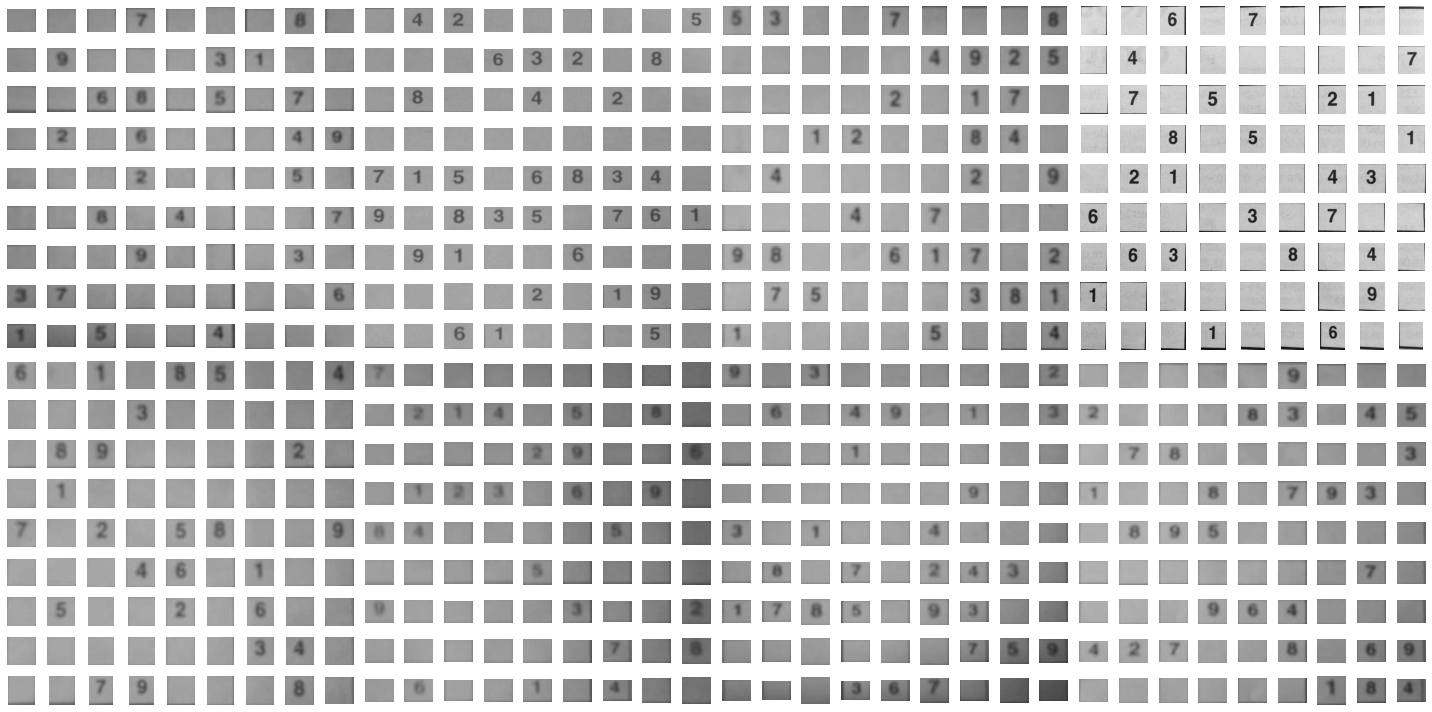

In [13]:
TEST_IMAGES = [1, 10, 100, 1000, 22, 40, 50, 61]
# Show the results from some test images.
alls = [get_img_and_data(f'image{i}') for i in TEST_IMAGES]
test_images = [i[0] for i in alls]
test_data = [i[1] for i in alls]
list_of_dicts = []
for i in test_images:
    list_of_dicts.append(get_segmentation_results(i))
digit_vals = [d['digit_vals_og_not_thresh'] for d in list_of_dicts]
show_8_81(digit_vals)

# Recognition
The following cell contains functions to actually perform the recognition. This includes loading the training data, preprocessing it, and training an LDA classifier. 

In [14]:
def get_cropped_digit(img: np.ndarray) -> np.ndarray:
    """Crops the image of a small digit to only contain the digit itself. Uses morphological labelling

    Args:
        img (np.ndarray): input cell

    Returns:
        np.ndarray: cropped image
    """
    img = img.copy()
    test = img < filters.threshold_otsu(img)
    labels = morph.label(test)
    largest = (-1, -1)
    # Only use middle part to ignore gridlines.
    test_ones = labels[10:-10, 10:-10]
    for u in np.unique(test_ones):
        if u == 0: # ignore background.
            continue
        largest = max(largest, ((test_ones == u).sum(), u))

    t = labels == largest[1]
    minrow = 10000
    maxrow = -1
    mincol = 10000
    maxcol = -1
    # Find the min and max rows to get the bounding box locations.
    for i in range(t.shape[0]):
        if (t[i, :]).sum() != 0:
            minrow = min(minrow, i)
            maxrow = max(maxrow, i)

    for i in range(t.shape[1]):
        if (t[:, i]).sum() != 0:
            mincol = min(mincol, i)
            maxcol = max(maxcol, i)

    img[:minrow, :] = 255
    img[:, :mincol] = 255
    img[maxrow:, :] = 255
    img[:, maxcol:] = 255
    # Crop out the digit.
    test = img[minrow:maxrow, mincol:maxcol]
    return test


def change_img_size(img: np.ndarray, SIZE: int) -> np.ndarray:
    """Resizes the image to SIZE x SIZE using bilinear interpolation
    """
    return resize(img, (SIZE, SIZE), anti_aliasing=False)


def get_train_test_data(SIZE: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Returns the train and testing set for the images to train and eval the recogniser on.

    Args:
        SIZE (int): size of image resizing. 16 is a good value

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: X_train, X_test, y_train, y_test
    """
    
    digits = defaultdict(lambda: [])
    # Read in images.
    for name in glob.glob('../data/images/train_data_imgs/*_v2/*.jpg'):
        digit = name.split("/")[-1].split('.jpg')[0][0]
        assert digit != '0', name
        img = cv2.imread(name, 0)
        # Crop the image.
        test = get_cropped_digit(img)
        digits[digit].append(test)

    Xs = []
    ys = []

    padded = {}
    # fix all digits by resizing.
    for key in digits:
        k = int(key)
        padded[k] = []
        for val in digits[key]:
            
            tt = change_img_size(val, SIZE)
            padded[k].append(tt)
            
            # Reshape to long 1D vector
            Xs.append(tt.reshape(tt.shape[0] * tt.shape[1]))
            ys.append(k)

    Xs = np.array(Xs)
    ys = np.array(ys)
    # Train test split, stratify to ensure classes are balanced.
    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.25, random_state=42, stratify=ys)
    return X_train, X_test, y_train, y_test


class DigitRecogniser:
    """Class that recognises digits
    """
    def __init__(self):
        self.SIZE = 16
        self.X_train, self.X_test, self.y_train, self.y_test = get_train_test_data(self.SIZE)

        # use LDA as the classifier
        self.clf = LinearDiscriminantAnalysis()
        self.clf.fit(self.X_train, self.y_train)
        print("Score on test data = ", self.clf.score(self.X_test, self.y_test))

    def predict(self, digit_to_predict: np.ndarray) -> int:
        # Predicts the digit value of the given image.
        test = get_cropped_digit(digit_to_predict)
        test = change_img_size(test)

        return self.clf.predict([test.reshape(-1)])[0]

    def predict_grid(self, non_empty: List[Tuple[int, int]], og_digit_vals: List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Takes in a list of non empty coordinates and the digit values in a 1D list and returns a list of predictions for each non empty cell,
            as well as a list of cropped images.

        Args:
            non_empty (List[Tuple[int, int]]): 
            og_digit_vals (List[np.ndarray]): 

        Returns:
            Tuple[List[np.ndarray], List[np.ndarray]]: predictions, imgs
        """

        to_predict = []
        imgs = []
        # For every non-empty cell
        for xi, yi in non_empty:
            index = yi * 9 + xi
            img = og_digit_vals[index].copy()
            # Preprocess in the same way as the training digits.
            test = get_cropped_digit(img)
            test = change_img_size(test, self.SIZE)
            # add the cropped image for showing results later on.
            imgs.append(test)
            to_predict.append(test.reshape(-1))
        to_predict = np.array(to_predict)
        predictions = self.clf.predict(to_predict)
        return predictions, imgs


def get_predicted_grid(predictions, non_empty):
    # Converts predictions and the coordinates of non-empty blocks to a 2d grid representing the sudoku puzzle.
    ans = np.zeros((9, 9))
    for (x, y), p in zip(non_empty, predictions):
        ans[y, x] = p
    return ans


# Evaluating the method in its entirety
Here we go over all the images, segment them and predict the values of the digits.


We also write the predicted grids to a text file, which can easily be parsed and solved using a library.

In [15]:
# Create the digit recogniser
predictor = DigitRecogniser()

# All images to test on.
names = glob.glob("../data/images/*.dat")
names = [n.split('/')[-1].split('.dat')[0] for n in names]
# Ignore images that we 'trained' on, so we get an unbiased result.
names = [n for n in names if int(n.replace('image', '')) not in TEST_IMAGES]
alls_eval = [get_img_and_data(n) for n in names]

# Get the images
eval_images = [i[0] for i in alls_eval]
eval_data = [i[1] for i in alls_eval]

all_answers = []
all_proper_images = []
all_proper_data = []
all_proper_names = []
faileds = []
# Go through all images and do the segmentation
for index, img in enumerate(eval_images):
    try:
        all_answers.append(get_segmentation_results(img))
        all_proper_images.append(img)
        all_proper_data.append(eval_data[index])
        all_proper_names.append(names[index])
    except Exception as e:
        # If the method failed. This is usually because it could not find 81 distinct cells.
        faileds.append((names[index], img, e))

Score on test data =  1.0


In [16]:
def grid_to_text(grid: np.ndarray, name: str):
    # Writes the sudoku grid to a text file.
    os.makedirs("parsed_grids", exist_ok=True)
    with open(f"parsed_grids/{name}.txt", 'w+') as f:
        string = ""
        for row in grid:
            string += " ".join([str(int(i)) for i in row]) + "\n"
        f.write(string)

# Evaluating results
overall_number_of_digits = 0
def evaluate_results(data: np.ndarray, answer: Dict[str, Any], index: int) -> Tuple[float, float, int]:
    """Evaluates the result from answer and compares it to data.
        Index is the index of this image in all_proper_images.
        This function also saves the predictions to ./parsed_grids

    Returns:
        Tuple[float, float, int]: fraction of locations predicted correctly, fractions of grids predicted perfectly and the amount of digits predicted correctly.
    """
    global overall_number_of_digits
    # Evaluate the results on all of the given images.
    predicted_numbers, preds_image = predictor.predict_grid(answer['non_empty'], answer['digit_vals_og_not_thresh'])
    predicted_grid = get_predicted_grid(predicted_numbers, answer['non_empty'])
    # Save to a text file.
    grid_to_text(predicted_grid, all_proper_names[index])

    # check if the locations of the digits are correct.
    predicted_locations_correctly = np.all((predicted_grid > 0) == (data > 0))
    mask = (predicted_grid > 0)
    data_pos = data > 0
    
    # Number of digits there were (union between the actual number and our predictions)
    K = np.logical_or(data_pos, mask)

    # Number of digits predicted correctly.
    t = (K * ((predicted_grid == data))).sum() #/ (K).sum()

    # How many numbers (and grids) were predicted perfectly.
    predicted_numbers_correctly = np.all((predicted_grid == data))
    
    # Total number of digits that we tried to predict.
    overall_number_of_digits += K.sum()
    return predicted_locations_correctly, predicted_numbers_correctly, t

scores = {
    'locations': 0,
    'numbers': 0,
    'total': 0,
    'total_digits': 0
}
for index, (d, a) in enumerate(zip(all_proper_data, all_answers)):
    try:
        loc, perfect, total_digits = evaluate_results(d, a, index)
        scores['locations'] += loc
        scores['numbers'] += perfect
        scores['total'] += perfect
        scores['total_digits'] += total_digits
    except Exception as e:
        pass
# Normalise
scores['total_digits'] = scores['total_digits'] / overall_number_of_digits

# Analysing the results from above

In [17]:
# Print the results.
# Fraction of images we didn't fail on.
fraction = len(all_proper_data) / (len(all_proper_data) + len(faileds))
def pretty(n):
    return str(int((round(n * 100) / 100) * 100)) + " %"

# How many overall
loc_all = pretty(fraction * scores['locations'] / len(all_proper_data))
digits_all = pretty(fraction * scores['total_digits'])
perfect_all = pretty(fraction *  scores['total'] / len(all_proper_data))

# How many when taking into account only those grids that we didn't fail on.
loc = pretty(scores['locations'] / len(all_proper_data))
digits = pretty(scores['total_digits'])
perfect = pretty(scores['total'] / len(all_proper_data))

df = pd.DataFrame({
        'Over All Images': [loc_all, digits_all, perfect_all],
        'Over Non Failed': [loc, digits, perfect],
}
)
df.index = (["Locations", "Digits in Total", "Perfect Prediction"])
if SAVE:
    df.to_latex("results/results_table.tex")
df

,Over All Images,Over Non Failed
Locations,78 %,93 %
Digits in Total,79 %,94 %
Perfect Prediction,56 %,68 %


In [18]:
print("Over all images\n" + "=" * 50)
print("Locations Correct =\t", pretty(fraction * scores['locations'] / len(all_proper_data)))
print("Numbers correct =\t", pretty(fraction * scores['total_digits']))
print("Total correct =\t\t",pretty(fraction *  scores['total'] / len(all_proper_data)))
print("\n" + "=" * 50 + "\n")
print("Over only images that didn't fail in the segmentation step\n" + "=" * 50)
print("Locations Correct =\t", pretty(scores['locations'] / len(all_proper_data)))
print("Numbers correct =\t", pretty(scores['total_digits'] ))
print("Total correct =\t\t", pretty(scores['total'] / len(all_proper_data)))
print("-" * 50)
print("Number of failed images =", len(faileds))

Over all images
Locations Correct =	 78 %
Numbers correct =	 79 %
Total correct =		 56 %


Over only images that didn't fail in the segmentation step
Locations Correct =	 93 %
Numbers correct =	 94 %
Total correct =		 68 %
--------------------------------------------------
Number of failed images = 29


# Generating Report Images
The following few cells make the images that are found in the report. To actually save the results to a file, you can simple set the SAVE variable to True at the beginning of this notebook.

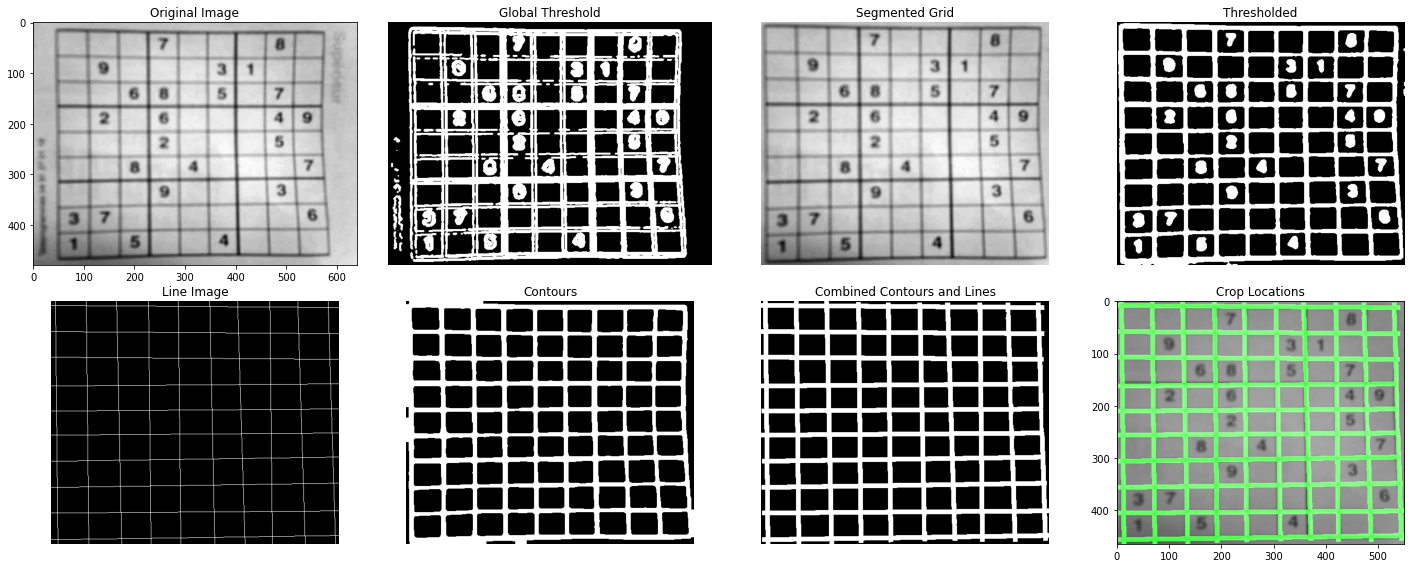

In [19]:
# Show intermediate steps.

TEST_IMAGES = [1, 10, 100, 1000, 22, 40, 50, 61]
alls = [get_img_and_data(f'image{i}') for i in TEST_IMAGES]
test_images = [i[0] for i in alls]
test_data = [i[1] for i in alls]
# Get results
all_results = [get_segmentation_results(i) for i in test_images]

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.ravel()
keys = ['og_binary', 'main', 'thresholded_img', 'line_img', 'contours', 'combined_contour_lines']
words = ['Original Image','Global Threshold', 'Segmented Grid', 'Thresholded', 'Line Image', 'Contours', 'Combined Contours and Lines', 'Crop Locations']
# Show intermediate states
for k, ax in zip(keys, axs[1:]):
    ax.imshow(all_results[0][k], cmap='gray')
    ax.axis('off')
axs[0].imshow(test_images[0], cmap='gray')
for word, ax in zip(words, axs):
    ax.set_title(word)
t = all_results[0]['main'].copy()
og_img_in_rgb = np.stack([t[:, :]] * 3,axis=2).astype(np.int32)
og_img_in_rgb[:, :, 1] += all_results[0]['combined_contour_lines'] * 255
og_img_in_rgb = np.clip(og_img_in_rgb, 0, 255)
axs[-1].imshow(og_img_in_rgb)
plt.tight_layout()
if SAVE:
    plt.savefig('results/segmentation.jpg')

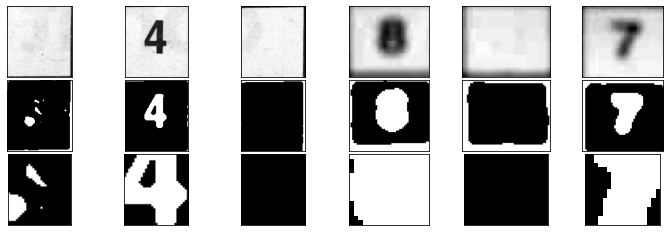

In [20]:
# Show which ones are empty and not
def plot_digit_empties():
    # From a few different images.
    v = all_results[3]['digit_vals']
    v2 = all_results[3]['digit_vals_og_not_thresh']
    v0 = all_results[0]['digit_vals']
    v20 = all_results[0]['digit_vals_og_not_thresh']
    def crop_mid(img):
        n = 3
        ly, lx = img.shape
        return img[ly//n: ly - ly//n, lx//n:lx-lx//n]
        
    vals_mid = [crop_mid(k) for k in v]
    vals_mid0 = [crop_mid(k) for k in v0]
    K = 6
    fig, axs = plt.subplots(3, K, figsize=(10, 20/K))
    for i in range(3):
        axs[0, i].imshow(v2[i+9], cmap='gray')
        axs[1, i].imshow(v[i+9], cmap='gray')
        axs[2, i].imshow(vals_mid[i+9], cmap='gray')
        
        s = 1 if i == 2 else 21
        axs[0, i + 3].imshow(v20[i + s], cmap='gray')
        axs[1, i + 3].imshow(v0[i + s], cmap='gray')
        axs[2, i + 3].imshow(vals_mid0[i + s], cmap='gray')

    for a in axs.ravel():
        a.tick_params( axis='both',which='both', bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False) 
        plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    if SAVE:
        plt.savefig("results/empty.jpg")
plot_digit_empties()

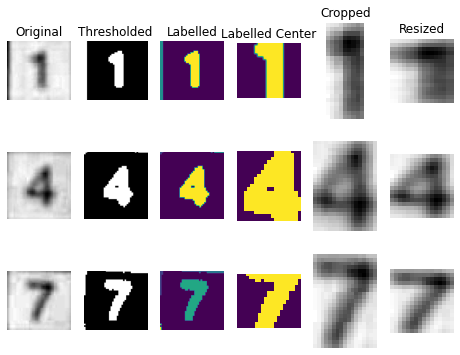

In [21]:
# Show the preprocessing steps of the digits.
SIZE = 16
digits = defaultdict(lambda: [])
ogImages = defaultdict(lambda: [])
for name in glob.glob('../data/images/train_data_imgs/*/*.jpg'):
    digit = name.split("/")[-1].split('.jpg')[0][0]
    img = cv2.imread(name, 0)
    test = get_cropped_digit(img)
    digits[digit].append(test)
    ogImages[digit].append(img)

Xs = []
ys = []


padded = {}
for key in digits:
    k = int(key)
    padded[k] = []
    for val in digits[key]:

        tt = change_img_size(val, SIZE)
        padded[k].append(tt)
        Xs.append(tt.reshape(tt.shape[0] * tt.shape[1]))
        ys.append(k)

fig, show_axs = plt.subplots(3, 6, figsize=(8, 6))
size = (3, 9)
figstep1, ax1 = plt.subplots(3, 1, figsize=size)
figstep2, ax2 = plt.subplots(3, 1, figsize=size)
figstep3, ax3 = plt.subplots(3, 1, figsize=size)
figstep4, ax4 = plt.subplots(3, 1, figsize=size)
figstep5, ax5 = plt.subplots(3, 1, figsize=size)
figstep6, ax6 = plt.subplots(3, 1, figsize=size)

all_axes = np.array([ax1, ax2, ax3, ax4, ax5, ax6]).T
axs = all_axes
labels = ['Original', 'Thresholded', 'Labelled', 'Labelled Center', 'Cropped', "Resized"]
for index, num in enumerate([1, 4, 7]):
    axs[index, 0].imshow(ogImages[str(num)][0], cmap='gray')
    show_axs[index, 0].imshow(ogImages[str(num)][0], cmap='gray')
    og = ogImages[str(num)][0].copy()
    og = og < filters.threshold_otsu(og)
    axs[index, 1].imshow(og, cmap='gray')
    show_axs[index, 1].imshow(og, cmap='gray')
    og = morph.label(og)
    
    axs[index, 2].imshow(og)
    show_axs[index, 2].imshow(og)
    og = og[10:-10, 10:-10]
    axs[index, 3].imshow(og)
    show_axs[index, 3].imshow(og)
    axs[index, 4].imshow(digits[str(num)][0], cmap='gray')
    show_axs[index, 4].imshow(digits[str(num)][0], cmap='gray')
    axs[index, 5].imshow(padded[num][0], cmap='gray')
    show_axs[index, 5].imshow(padded[num][0], cmap='gray')
    if index == 0:
        for i in range(len(labels)):
            show_axs[index,i].set_title(labels[i])
for a, a2 in zip(axs.ravel(), show_axs.ravel()):
    a.axis('off')
    a2.axis('off')

plt.margins(0,0)

if SAVE:
    for label, fig in zip(labels, [figstep1, figstep2, figstep3, figstep4, figstep5, figstep6]):
        fig.savefig(f'results/{label.replace(" ", "")}.jpg', pad_inches = 0)
for i in labels:
    plt.close()

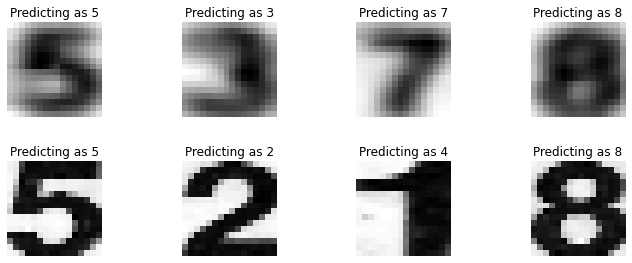

In [22]:
# Show predictions
all_ans = [predictor.predict_grid(all_results[i]['non_empty'], all_results[i]['digit_vals_og_not_thresh']) for i in range(len(all_results))]
N = 2
preds, cropped_imgs_recog = all_ans[N]
fig, axs = plt.subplots(2, 4, figsize=(10, 4))
axs = axs.ravel()
for ax, pred, img in zip(axs[:4], preds, cropped_imgs_recog):    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Predicting as {pred}")
preds, cropped_imgs_recog = all_ans[3]
for ax, pred, img in zip(axs[4:], preds[5:], cropped_imgs_recog[5:]):    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Predicting as {pred}")
plt.tight_layout()
for a in axs: a.axis('off')
if SAVE:
    plt.savefig('results/predictions.jpg')

# Failure Cases
Here we go over some failure cases and show the intermediate results to get an idea of why they failed

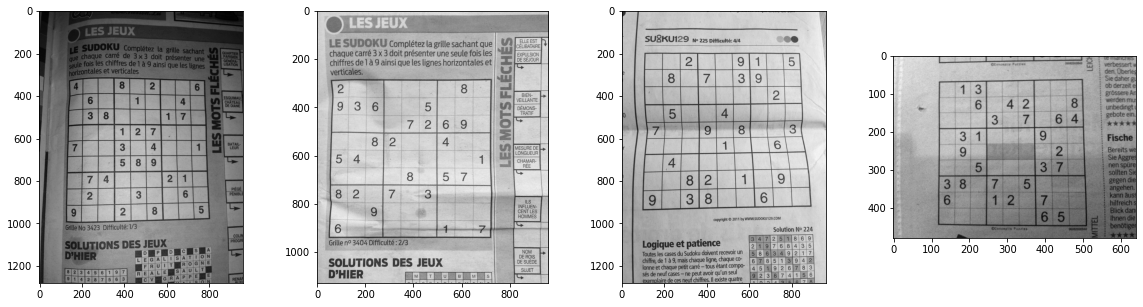

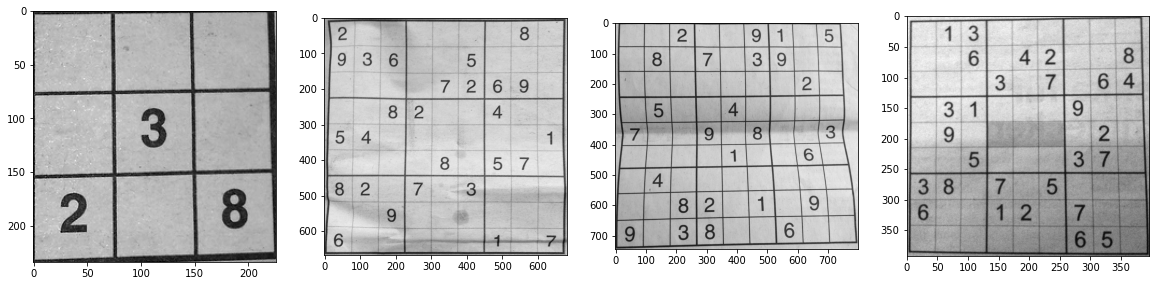

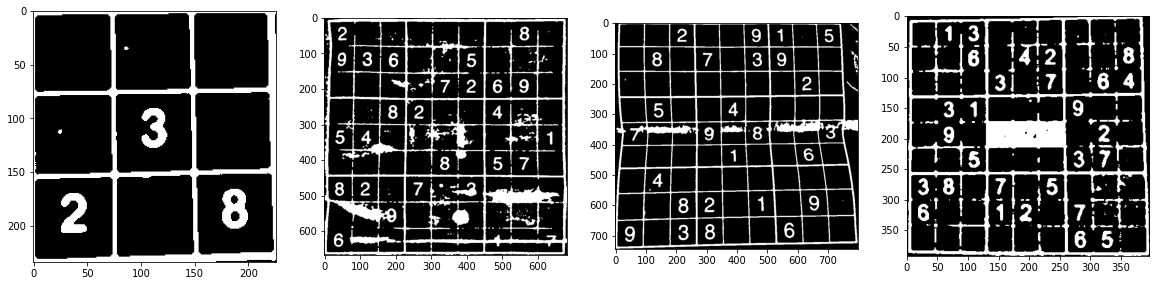

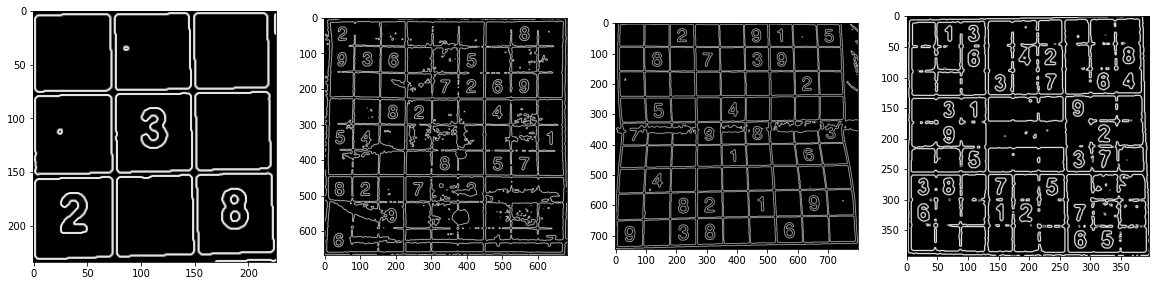

In [23]:
# These illustrate some failure cases.
FAILED_IMGS = ['image1070', 'image1049', 'image1087', 'image204']
def show_4(imgs):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs = axs.ravel()
    for img, ax in zip(imgs, axs):
        ax.imshow(img, cmap='gray')

bads = [get_img_and_data(f)[0] for f in FAILED_IMGS]
show_4(bads)

test_images = bads
if SAVE:
    plt.savefig("./results/bad_og.png")
    
mains = [get_main_sudoku_grid_from_image(img)[0] for img in test_images]
show_4(mains)
if SAVE:
    plt.savefig("./results/bad_main.png")
thresholded_imgs = [thresh(img) for img in mains]

show_4(thresholded_imgs)
if SAVE:
    plt.savefig("./results/bad_thresh.png")

edges = [edge(img) for img in thresholded_imgs]
show_4(edges)
if SAVE:
    plt.savefig("./results/bad_edges.png")